In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [3]:
PATH = "../datasets/yeast_v4"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [5]:
ds_name = "yeast_v4"
test_dirs, train_dirs = dataset_source(data_path)
stats_tuple = Statistics.per_dataset(test_dirs, train_dirs, save_name=ds_name)

8
working on a dataset with length: 714


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [1]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_tuple)

NameError: name 'get_data' is not defined

In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


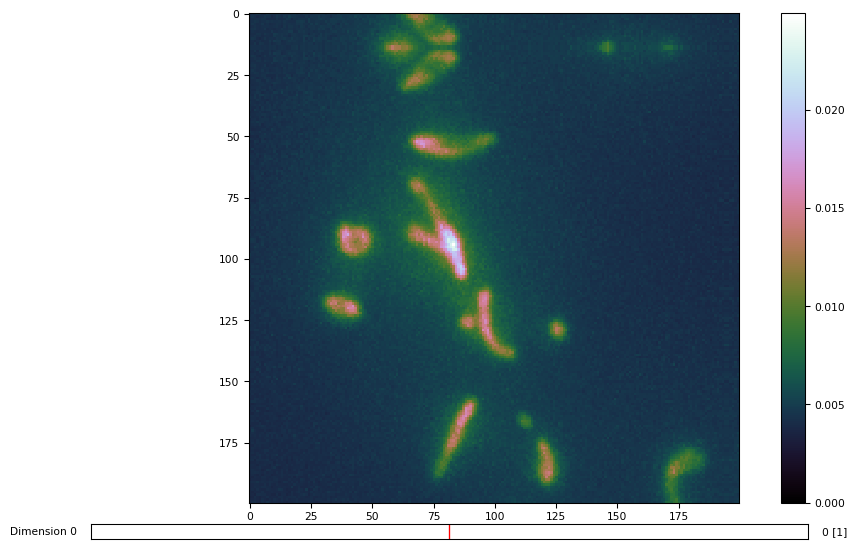

In [10]:
idx = 0
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [11]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [12]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [13]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [15]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], NUM_CLASSES), data)

In [16]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', tensor(510))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
            

In [17]:
wd=1e-5

In [20]:
learn.lr_find()

[0]: 100.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      43.623375  nan        0.285714  



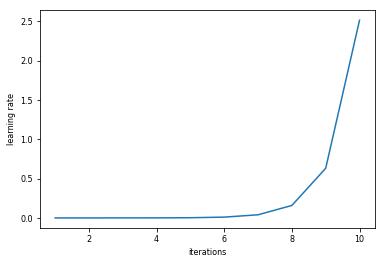

In [26]:
learn.sched.plot_lr()

In [27]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]: 100.0%                                               
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      29.646364  24.636447  0.285714  
[0]:  0.0%                                                
[1]: 100.0%
[2]:  0.0%
[3]:  0.0%
    1      19.221071  5.996483   0.247619  
[0]:  0.0%                                               
[1]:  0.0%
[2]:  0.0%
[3]: 100.0%
    2      13.045314  2.521989   0.228571  
[0]:  0.0%                                                
[1]: 80.77%
[2]:  0.0%
[3]: 8.333%
    3      9.335584   2.082336   0.238095  
[0]: 96.67%                                               
[1]: 23.08%
[2]:  0.0%
[3]:  0.0%
    4      7.345543   3.290215   0.333333  
[0]: 76.67%                                               
[1]: 42.31%
[2]:  0.0%
[3]: 16.67%
    5      5.965097   1.450393   0.352381  
[0]: 53.33%                                               
[1]: 3.846%
[2]:  0.0%
[3]: 62.5%
    6      4.851616   1.408664   0.35238

[1.1670512960070656, 0.5142857086090814]

In [28]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

[0]: 76.67%                                               
[1]: 15.38%
[2]:  8.0%
[3]: 50.0%
epoch      trn_loss   val_loss   accuracy   
    0      1.002691   1.188387   0.457143  
[0]: 46.67%                                               
[1]: 11.54%
[2]:  0.0%
[3]: 66.67%
    1      1.0185     1.17722    0.447619  
[0]: 43.33%                                                
[1]: 38.46%
[2]:  8.0%
[3]: 62.5%
    2      0.988991   1.147853   0.533333  
[0]: 60.0%                                                 
[1]: 46.15%
[2]:  4.0%
[3]: 54.17%
    3      0.968563   1.16128    0.504762  
[0]: 66.67%                                                
[1]: 61.54%
[2]:  4.0%
[3]: 45.83%
    4      0.960605   1.178228   0.514286  
[0]: 36.67%                                                
[1]: 30.77%
[2]:  8.0%
[3]: 70.83%
    5      0.967265   1.109079   0.52381   
[0]: 30.0%                                                 
[1]: 38.46%
[2]:  0.0%
[3]: 70.83%
    6      0.958571   1.177239

[0.9558275608789353, 0.6095238089561462]

In [29]:
learn.save('Objective_A_ResNets_per_dataset')

In [30]:
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[0], axis=1)

[[21  4  5  4]                               
 [ 3 19  7  5]
 [ 2  0  4  2]
 [ 4  3  9 13]]


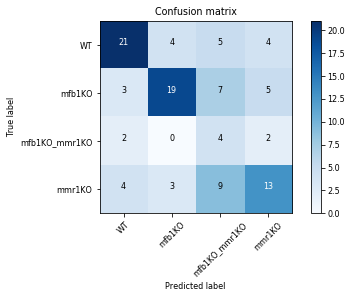

In [32]:
from sklearn.metrics import confusion_matrix
from resources.plots import *
import pickle
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)
with open('confusion_matrix.32epochs.per_dataset.array','wb') as file:
    pickle.dump(cm,file)
plot_confusion_matrix(cm, data.classes)

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.save('tmp_resnet_clr')